In [8]:
import torch
import numpy as np
import random
from scipy.optimize import linprog
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/ukdemand_09-23.csv', parse_dates=['settlement_date'])
df.head()

,settlement_date,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
0,2009-01-01 00:00:00,1,0:00:00,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,1
1,2009-01-01 00:30:00,2,0:30:00,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,1
2,2009-01-01 01:00:00,3,1:00:00,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,1
3,2009-01-01 01:30:00,4,1:30:00,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,1
4,2009-01-01 02:00:00,5,2:00:00,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,1


In [28]:
n = len(df['settlement_date'])
p = df['embedded_wind_generation'] + df['embedded_solar_generation']
d = df['tsd']

In [4]:
# Dynimic Programming

def electricity_load_optimization(n, p, d):
    # n = number of time periods
    # p = list of power generation capacity at each period
    # d = list of electricity demand at each period
    
    # Initialize an array to store the minimum cost of satisfying demand
    cost = [0] * (n + 1)
    
    # Loop through each time period
    for i in range(1, n + 1):
        # Calculate the cost of satisfying demand for this period by
        # considering the minimum cost of the previous period and
        # the cost of generating the necessary power for this period
        cost[i] = min([cost[j] + abs(p[j] - d[i - 1]) for j in range(i)])
    
    # Return the minimum cost of satisfying demand for all periods
    return cost[n]

# Example usage
n = 5
p = [3, 4, 5, 6, 7]
d = [2, 5, 6, 8, 9]
print(electricity_load_optimization(n, p, d))


6


In [44]:
# ANN
# 
# # Generate sample data
np.random.seed(0)
#n = 500
n = len(df)
#p = torch.tensor(np.random.rand(n) * 10, dtype=torch.float32).unsqueeze(1)
#print(p.shape)
p = torch.tensor(p, dtype=torch.float32).unsqueeze(1)
#d = torch.tensor(np.random.rand(n) * 10, dtype=torch.float32).unsqueeze(1)
d = torch.tensor(d, dtype=torch.float32).unsqueeze(1)

# Build the ANN model
model = torch.nn.Sequential(
    torch.nn.Linear(1, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 1)
)

# Define the loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model on the sample data
epoch_range = range(100)
mse_tracker = []
for epoch in epoch_range:
    # Make predictions
    predictions = model(p)
    
    # Calculate the loss
    loss = criterion(predictions, d)
    if epoch % 10 == 0:
        if epoch > 10:
            delta_loss = round(((loss.item() - mse_tracker[-10]) / mse_tracker[-10])*100, 2)
        else:
            delta_loss = "N/A"
        print(f'Epoch: {epoch} -- Loss: {loss.item()} -- % Diff: {delta_loss}%')
    mse_tracker.append(loss.item())
    
    # Zero the gradients
    optimizer.zero_grad()
    
    # Compute gradients
    loss.backward()
    
    # Update parameters
    optimizer.step()

# Calculate the mean squared error between the predictions and the actual values
mse = torch.nn.functional.mse_loss(predictions, d)
print('----')
print(f"MSE = {mse.item():,}")
print(f"RMSE | MAE = {round(np.sqrt(mse.item()), 2):,}")
print('----')

C:\Users\Ty Martz\AppData\Local\Temp\ipykernel_8664\1575328233.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p = torch.tensor(p, dtype=torch.float32).unsqueeze(1)
C:\Users\Ty Martz\AppData\Local\Temp\ipykernel_8664\1575328233.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d = torch.tensor(d, dtype=torch.float32).unsqueeze(1)


Epoch: 0 -- Loss: 1176128128.0 -- % Diff: N/A%
Epoch: 10 -- Loss: 1146828288.0 -- % Diff: N/A%
Epoch: 20 -- Loss: 1067754432.0 -- % Diff: -6.9%
Epoch: 30 -- Loss: 890104768.0 -- % Diff: -16.64%
Epoch: 40 -- Loss: 684306048.0 -- % Diff: -23.12%
Epoch: 50 -- Loss: 669721152.0 -- % Diff: -2.13%
Epoch: 60 -- Loss: 654358656.0 -- % Diff: -2.29%
Epoch: 70 -- Loss: 654271808.0 -- % Diff: -0.01%
Epoch: 80 -- Loss: 651863488.0 -- % Diff: -0.37%
Epoch: 90 -- Loss: 651818240.0 -- % Diff: -0.01%
----
MSE = 651,393,792.0
RMSE | MAE = 2.6e+04
----


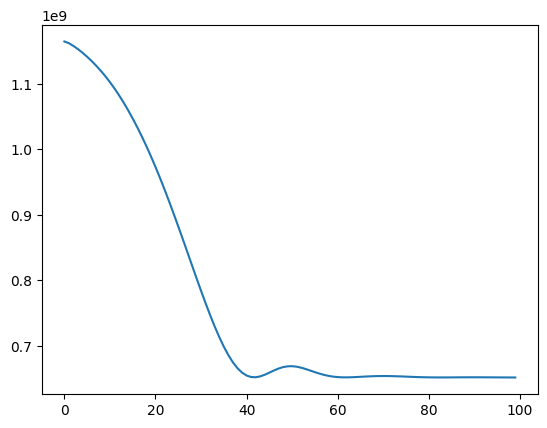

In [31]:
plt.plot(epoch_range, mse_tracker)

In [ ]:
# Genetic Algorithm

# Generate sample data
np.random.seed(0)
n = 500
p = np.random.rand(n) * 10
d = np.random.rand(n) * 10

def generate_random_chromosome(n):
    return np.random.rand(n) * 10

def calculate_fitness(chromosome, p, d):
    return np.mean((chromosome - d) ** 2)

def mutate_chromosome(chromosome):
    mutation_index = random.randint(0, len(chromosome) - 1)
    chromosome[mutation_index] += np.random.randn() * 0.1
    return chromosome

def generate_next_generation(population, p, d):
    # Evaluate the fitness of each chromosome in the population
    fitness = [calculate_fitness(chromosome, p, d) for chromosome in population]
    
    # Select the best performing chromosomes for reproduction
    selected_chromosomes = [population[i] for i in np.argsort(fitness)[:int(len(population) / 2)]]
    
    # Generate the next generation of chromosomes by mating the selected chromosomes
    next_generation = []
    while len(next_generation) < len(population):
        parent1, parent2 = random.sample(selected_chromosomes, 2)
        child = (parent1 + parent2) / 2
        next_generation.append(child)
    
    # Mutate some of the chromosomes in the next generation
    for i in range(len(next_generation)):
        if random.random() < 0.1:
            next_generation[i] = mutate_chromosome(next_generation[i])
    
    return next_generation

# Initialize the population of chromosomes
population = [generate_random_chromosome(n) for i in range(100)]

# Evolve the population for 100 generations
for i in range(100):
    population = generate_next_generation(population, p, d)

# Select the best chromosome
best_chromosome = population[np.argmin([calculate_fitness(chromosome, p, d) for chromosome in population])]

# Calculate the mean squared error between the best chromosome and the actual values
mse = np.mean((best_chromosome - d) ** 2)
print(mse)


In [ ]:
# Linear Programming

# Generate sample data
np.random.seed(0)
n = 500
p = np.random.rand(n) * 10
d = np.random.rand(n) * 10

# Define the objective function
c = np.ones(n)

# Define the inequality constraints
A = np.array([p, -p])
b = np.array([d.sum(), -d.sum()])

# Define the bounds on the variables
bounds = [(0, None) for i in range(n)]

# Solve the linear programming problem
result = linprog(c, A_ub=A, b_ub=b, bounds=bounds, method="simplex")

# Calculate the mean squared error between the solution and the actual values
mse = np.mean((result.x - d) ** 2)
print(mse)


In [ ]:
# Particle Swarm

import numpy as np

# Generate sample data
np.random.seed(0)
n = 500
p = np.random.rand(n) * 10
d = np.random.rand(n) * 10

def generate_random_particle(n):
    return np.random.rand(n) * 10

def calculate_fitness(particle, p, d):
    return np.mean((particle - d) ** 2)

def update_velocity(particle, velocity, pbest, gbest, w, c1, c2):
    r1 = np.random.rand(n)
    r2 = np.random.rand(n)
    velocity = w * velocity + c1 * r1 * (pbest - particle) + c2 * r2 * (gbest - particle)
    particle = particle + velocity
    return particle, velocity

# Initialize the swarm of particles
swarm = [generate_random_particle(n) for i in range(100)]
velocities = [np.zeros(n) for i in range(100)]
pbest = swarm.copy()

# Run the particle swarm optimization for 100 iterations
for t in range(100):
    fitness = [calculate_fitness(particle, p, d) for particle in swarm]
    gbest = swarm[np.argmin(fitness)]
    
    for i in range(len(swarm)):
        if calculate_fitness(pbest[i], p, d) > calculate_fitness(swarm[i], p, d):
            pbest[i] = swarm[i].copy()
        
        swarm[i], velocities[i] = update_velocity(swarm[i], velocities[i], pbest[i], gbest, 0.5, 2, 2)

# Select the best particle
best_particle = swarm[np.argmin(fitness)]

# Calculate the mean squared error between the best particle and the actual values
mse = np.mean((best_particle - d) ** 2)
print(mse)
